# Skezi Sentiment Analysis on Drug Reviews
### Prepared by Siva Adharsh

## Loading and Cleaning Data

In [6]:
import pandas as pd

df = pd.read_csv("drugLib_raw.tsv", sep="\t")
df.info()
print(df.columns)
df.head()

# Retunring missing values in each column
print(df.isnull().sum())

df = df.drop(columns=['Unnamed: 0'])
print(df.columns)
df = df.dropna(subset=['commentsReview'])

# Ensuring that 'rating' is numeric before filling missing values
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['rating'] = df['rating'].fillna(df['rating'].median())

df.head()
df.describe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107 entries, 0 to 3106
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         3107 non-null   int64 
 1   urlDrugName        3107 non-null   object
 2   rating             3107 non-null   int64 
 3   effectiveness      3107 non-null   object
 4   sideEffects        3107 non-null   object
 5   condition          3106 non-null   object
 6   benefitsReview     3089 non-null   object
 7   sideEffectsReview  3032 non-null   object
 8   commentsReview     3095 non-null   object
dtypes: int64(2), object(7)
memory usage: 218.6+ KB
Index(['Unnamed: 0', 'urlDrugName', 'rating', 'effectiveness', 'sideEffects',
       'condition', 'benefitsReview', 'sideEffectsReview', 'commentsReview'],
      dtype='object')
Unnamed: 0            0
urlDrugName           0
rating                0
effectiveness         0
sideEffects           0
condition             1
ben

<bound method NDFrame.describe of            urlDrugName  rating           effectiveness  \
0            enalapril       4        Highly Effective   
1     ortho-tri-cyclen       1        Highly Effective   
2              ponstel      10        Highly Effective   
3             prilosec       3    Marginally Effective   
4               lyrica       2    Marginally Effective   
...                ...     ...                     ...   
3102           vyvanse      10        Highly Effective   
3103            zoloft       1             Ineffective   
3104           climara       2    Marginally Effective   
3105         trileptal       8  Considerably Effective   
3106          micardis       4    Moderately Effective   

                        sideEffects                               condition  \
0                 Mild Side Effects  management of congestive heart failure   
1               Severe Side Effects                        birth prevention   
2                   No Side Effects                        menstrual cramps   
3                 Mild Side Effects                             acid reflux   
4               Severe Side Effects                            fibromyalgia   
...                             ...                                     ...   
3102              Mild Side Effects                                    adhd   
3103  Extremely Severe Side Effects                              depression   
3104          Moderate Side Effects                       total hysterctomy   
3105              Mild Side Effects                                epilepsy   
3106          Moderate Side Effects                     high blood pressure   

                                         benefitsReview  \
0     slowed the progression of left ventricular dys...   
1     Although this type of birth control has more c...   
2     I was used to having cramps so badly that they...   
3     The acid reflux went away for a few months aft...   
4     I think that the Lyrica was starting to help w...   
...                                                 ...   
3102  Increased focus, attention, productivity. Bett...   
3103    Emotions were somewhat blunted. Less moodiness.   
3104                                                ---   
3105               Controlled complex partial seizures.   
3106  The drug Micardis did seem to alleviate my hig...   

                                      sideEffectsReview  \
0     cough, hypotension , proteinuria, impotence , ...   
1     Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...   
2            Heavier bleeding and clotting than normal.   
3     Constipation, dry mouth and some mild dizzines...   
4     I felt extremely drugged and dopey.  Could not...   
...                                                 ...   
3102  Restless legs at night, insomnia, headache (so...   
3103  Weight gain, extreme tiredness during the day,...   
3104  Constant issues with the patch not staying on....   
3105                         Dizziness, fatigue, nausea   
3106  I find when I am taking Micardis that I tend t...   

                                         commentsReview  
0     monitor blood pressure , weight and asses for ...  
1     I Hate This Birth Control, I Would Not Suggest...  
2     I took 2 pills at the onset of my menstrual cr...  
3     I was given Prilosec prescription at a dose of...  
4                                             See above  
...                                                 ...  
3102  I took adderall once as a child, and it made m...  
3103  I was on Zoloft for about 2 years total. I am ...  
3104                                                ---  
3105  Started at 2 doses of 300 mg a day and worked ...  
3106           I take Micardis in pill form once daily.  

[3095 rows x 8 columns]>

## Sentiment Labelling

In [7]:
def categorize_sentiment(rating):
    if rating >= 5:
        return 1  # positive
    else:
        return 0  # negative

df['sentiment'] = df['rating'].apply(categorize_sentiment)

print(df['sentiment'].value_counts())


sentiment
1    2439
0     656
Name: count, dtype: int64


## Feature Extraction

In [8]:
import re

def basic_clean_text(text):
    if isinstance(text, str):
        text = text.lower()  # lowercase
        text = re.sub(r'http\S+', '', text)  # removing URLs
        text = re.sub(r'[^a-zA-Z0-9.,!?\'" ]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()  # removing extra spaces
    return text

df['cleaned_review'] = df['commentsReview'].apply(basic_clean_text)

# original vs cleaned
df[['commentsReview', 'cleaned_review']].head(10)
df['full_review'] = df[['benefitsReview', 'sideEffectsReview', 'commentsReview']].fillna('').agg(' '.join, axis=1)

# lowercasing and removing special characters
df['full_review'] = df['full_review'].str.lower().str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)



In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialising TF-IDF Vectoriser
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(df['full_review'])
X_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Dependent variable
y = df['sentiment']


In [10]:
from sklearn.feature_selection import chi2
import numpy as np
import pandas as pd

#  chi-squared scores
chi2_scores, p_values = chi2(X_df, y)

feature_scores = pd.DataFrame({'Feature': vectorizer.get_feature_names_out(), 'Chi2 Score': chi2_scores})

#  top 20 most relevant features
top_features = feature_scores.sort_values(by="Chi2 Score", ascending=False).head(20)
print(top_features)

           Feature  Chi2 Score
3972        severe   11.112083
3562          rash   10.779590
3575      reaction   10.227460
159      abdominal    8.957512
2076      horrible    8.869469
4932         worse    8.633131
2382        keflex    7.298642
4565          told    6.410795
2942    nightmares    6.207362
4803      vomiting    6.130809
1602       extreme    5.738875
1271  discontinued    5.380517
544       benadryl    4.470181
4476      terrible    4.433946
1311        doctor    4.388185
1229          died    4.353588
4846      weakness    4.338211
2596    lthyroxine    4.176360
4805       vytorin    4.100433
1443     emergency    3.946906


## Logistic Regression Model

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42, stratify=y)

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8045234248788369

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.08      0.15       131
           1       0.80      1.00      0.89       488

    accuracy                           0.80       619
   macro avg       0.86      0.54      0.52       619
weighted avg       0.83      0.80      0.73       619



In [22]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for positive
y_prob = model.predict_proba(X_test)[:, 1]

# ROC and AUC score
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)


## Random Forest Model

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]


fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)



print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))



Random Forest Accuracy: 0.789983844911147

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.01      0.02       131
           1       0.79      1.00      0.88       488

    accuracy                           0.79       619
   macro avg       0.89      0.50      0.45       619
weighted avg       0.83      0.79      0.70       619



## SVM Model

In [18]:
svm_model = SVC(kernel='linear', C=1, probability=True)
svm_model.fit(X_train, y_train)

# Predict
y_pred_svm = svm_model.predict(X_test)
y_prob_svm = svm_model.predict_proba(X_test)[:, 1]

fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)



print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))



SVM Accuracy: 0.8206785137318255

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.22      0.34       131
           1       0.82      0.98      0.90       488

    accuracy                           0.82       619
   macro avg       0.79      0.60      0.62       619
weighted avg       0.81      0.82      0.78       619



## Evaluation of Models

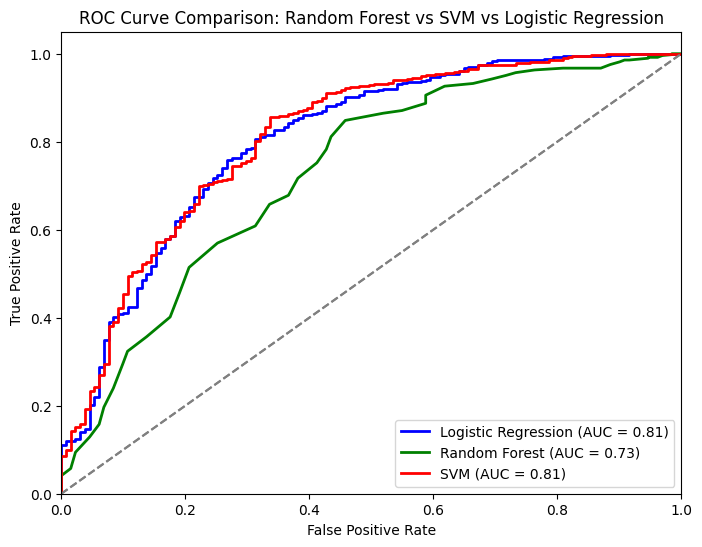

In [45]:
plt.figure(figsize=(8, 6))

plt.plot(fpr, tpr, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

#Random Forest ROC
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')

#SVM ROC Curve
plt.plot(fpr_svm, tpr_svm, color='red', lw=2, label=f'SVM (AUC = {roc_auc_svm:.2f})')

# Ref line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Random Forest vs SVM vs Logistic Regression')
plt.legend(loc="lower right")
plt.show()


## Side Effects Analysis

### General Impact of Side Effects on Sentiment

side_effects_mentioned
1    3021
0      74
Name: count, dtype: int64
                            mean  count
side_effects_mentioned                 
0                       8.310811     74
1                       6.977491   3021
sentiment                      0         1
side_effects_mentioned                    
0                       0.081081  0.918919
1                       0.215161  0.784839


<Figure size 800x600 with 0 Axes>

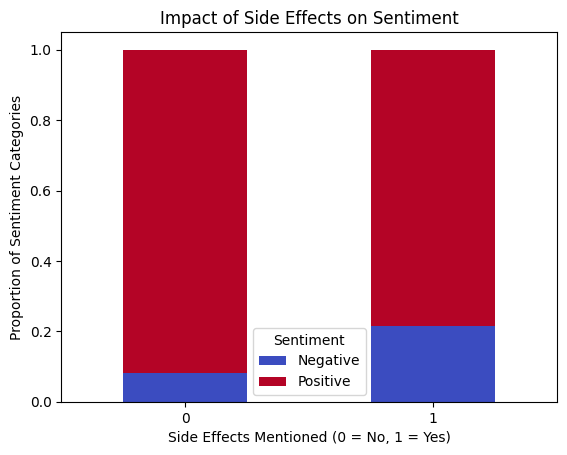

In [27]:
df['side_effects_mentioned'] = df['sideEffectsReview'].apply(lambda x: 1 if isinstance(x, str) and len(x.strip()) > 0 else 0)

print(df['side_effects_mentioned'].value_counts())

rating_comparison = df.groupby('side_effects_mentioned')['rating'].agg(['mean', 'count'])
print(rating_comparison)

df['sentiment'] = df['rating'].apply(lambda x: 1 if x >= 5 else 0)

sentiment_analysis = df.groupby('side_effects_mentioned')['sentiment'].value_counts(normalize=True).unstack()
print(sentiment_analysis)

plt.figure(figsize=(8, 6))
sentiment_analysis.plot(kind='bar', stacked=True, colormap='coolwarm')
plt.xlabel("Side Effects Mentioned (0 = No, 1 = Yes)")
plt.ylabel("Proportion of Sentiment Categories")
plt.title("Impact of Side Effects on Sentiment")
plt.legend(title="Sentiment", labels=["Negative", "Positive"])
plt.xticks(rotation=0)
plt.show()


### Relationship Between Rating and Side Effects Category

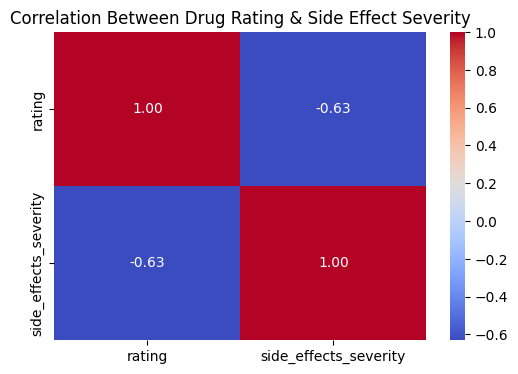

<ipython-input-36-cb8033e1b77c>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="side_effects_severity", y="rating", palette="coolwarm")


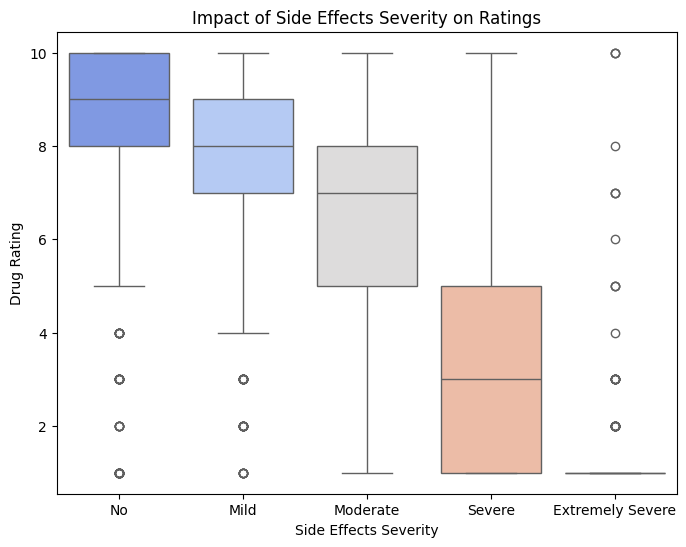

In [36]:
# Define severity mapping
severity_mapping = {
    "No Side Effects": 0,
    "Mild Side Effects": 1,
    "Moderate Side Effects": 2,
    "Severe Side Effects": 3,
    "Extremely Severe Side Effects": 4
}

# Side effect categories mapped to numerical values
df['side_effects_severity'] = df['sideEffects'].map(severity_mapping)
df[['sideEffects', 'side_effects_severity', 'rating']].head()

side_effects_correlation = df[['rating', 'side_effects_severity']].corr(method='spearman')

plt.figure(figsize=(6, 4))
sns.heatmap(side_effects_correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Drug Rating & Side Effect Severity")
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x="side_effects_severity", y="rating", palette="coolwarm")
plt.xticks([0, 1, 2, 3, 4], ["No", "Mild", "Moderate", "Severe", "Extremely Severe"])
plt.xlabel("Side Effects Severity")
plt.ylabel("Drug Rating")
plt.title("Impact of Side Effects Severity on Ratings")
plt.show()


## Summary Charts and Interesting Findings

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
from wordcloud import WordCloud
import plotly.graph_objects as go

severity_mapping = {
    "No Side Effects": 0,
    "Mild Side Effects": 1,
    "Moderate Side Effects": 2,
    "Severe Side Effects": 3,
    "Extremely Severe Side Effects": 4
}
df['side_effects_severity'] = df['sideEffects'].map(severity_mapping)

# Extracting Sentiment Score from Text Reviews
sia = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['commentsReview'].apply(lambda x: sia.polarity_scores(x)['compound'] if isinstance(x, str) else 0)


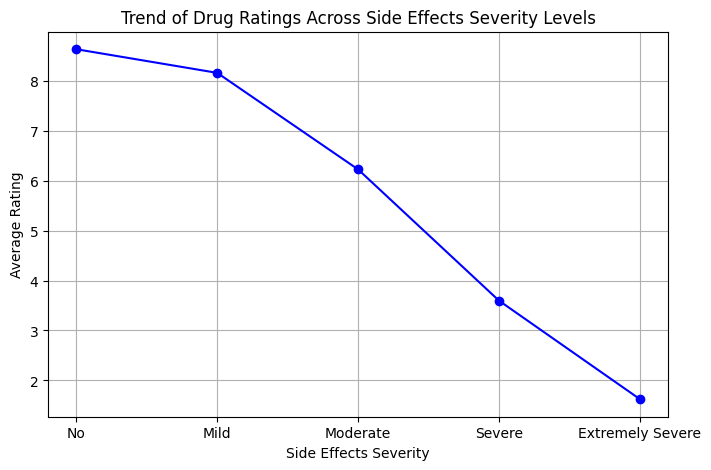

In [38]:
plt.figure(figsize=(8, 5))
df.groupby("side_effects_severity")['rating'].mean().plot(kind='line', marker='o', color='blue')
plt.xlabel("Side Effects Severity")
plt.ylabel("Average Rating")
plt.title("Trend of Drug Ratings Across Side Effects Severity Levels")
plt.xticks(ticks=[0,1,2,3,4], labels=["No", "Mild", "Moderate", "Severe", "Extremely Severe"])
plt.grid(True)
plt.show()


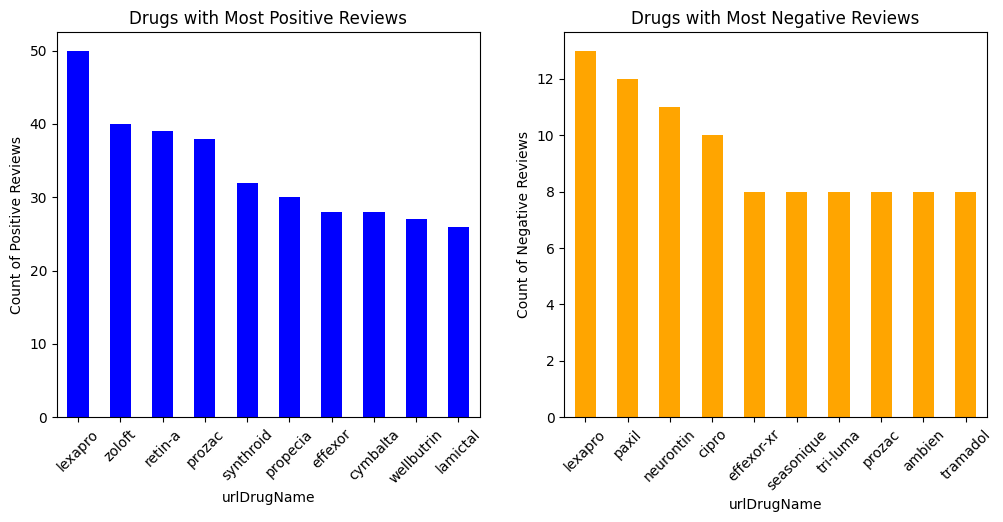

<ipython-input-44-af44d42744b3>:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




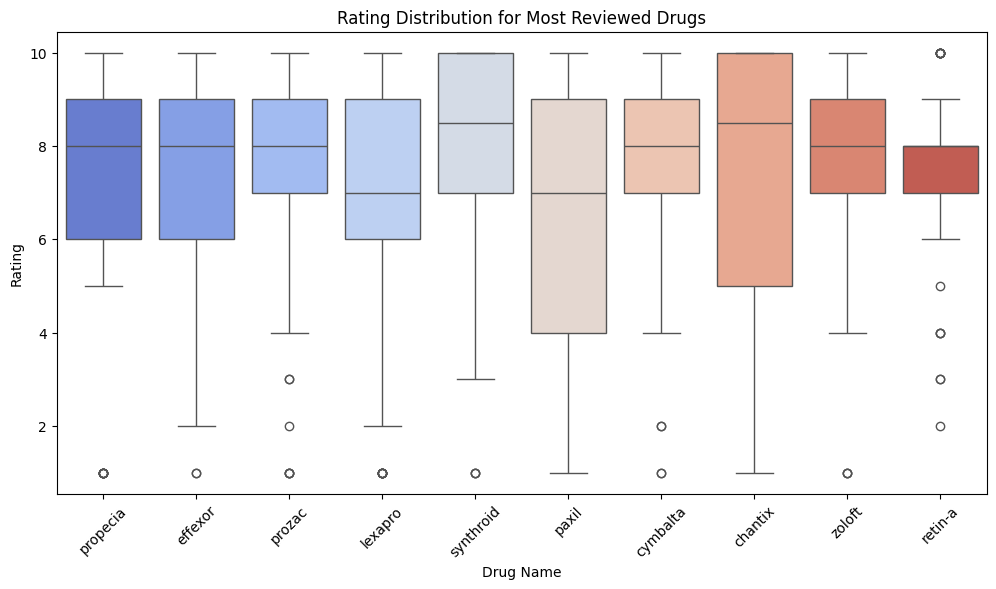

In [44]:
plt.figure(figsize=(12, 5))

# Top 10 drugs with most +ve sentiment
top_sentiment_drugs = df[df['sentiment'] == 1]['urlDrugName'].value_counts().head(10)
plt.subplot(1, 2, 1)
top_sentiment_drugs.plot(kind='bar', color='blue')
plt.title("Drugs with Most Positive Reviews")
plt.ylabel("Count of Positive Reviews")
plt.xticks(rotation=45)

# Top 10 drugs with most -ve sentiment
worst_sentiment_drugs = df[df['sentiment'] == 0]['urlDrugName'].value_counts().head(10)
plt.subplot(1, 2, 2)
worst_sentiment_drugs.plot(kind='bar', color='orange')
plt.title("Drugs with Most Negative Reviews")
plt.ylabel("Count of Negative Reviews")
plt.xticks(rotation=45)

plt.show()

# Distribution of Ratings Across Top 10 most reviewed drugs
top_reviewed_drugs = df['urlDrugName'].value_counts().head(10).index
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[df['urlDrugName'].isin(top_reviewed_drugs)], x="urlDrugName", y="rating", palette="coolwarm")
plt.xticks(rotation=45)
plt.xlabel("Drug Name")
plt.ylabel("Rating")
plt.title("Rating Distribution for Most Reviewed Drugs")
plt.show()
